In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 10 Arms Test-Bed Used for Experiments
Two questions to be answeared: 1. how epsilon change influences epsilon-greedy algo in stationary setting; 2. how alpha weighted-average helps the agent behavior better in none-stationary setting

## 1. epsilon-greedy update
The agent has its estimation of true value of actions q(a); at every step, it usually acts greedily(chooseing action with highest estimated value) but with epsilon changce to choose actions randomly.

In [11]:
# set envrionment
class k_armed_bandith(object):
    def __init__(self, k):
        self._k = k
        self.q_a = np.random.randn(k) # generate true value for each action
    
    def sent_reward(self, action_idx):
        # value is deterministic, but reward is stochastic around its true value
        # so every step, if action a is performed by an agent, then the agent will receive reward sampled from n(q(a), 1);
        return np.random.normal(loc=self.q_a[action_idx], scale=1.0)
    def reset(self):
        pass
    
    @property
    def k(self):
        return self._k
    
env_10_arms = k_armed_bandith(10) # use 10 arms test-bed setting
env_10_arms.sent_reward(2) # action 2(index from 0) is performed 

-0.05785551921821688

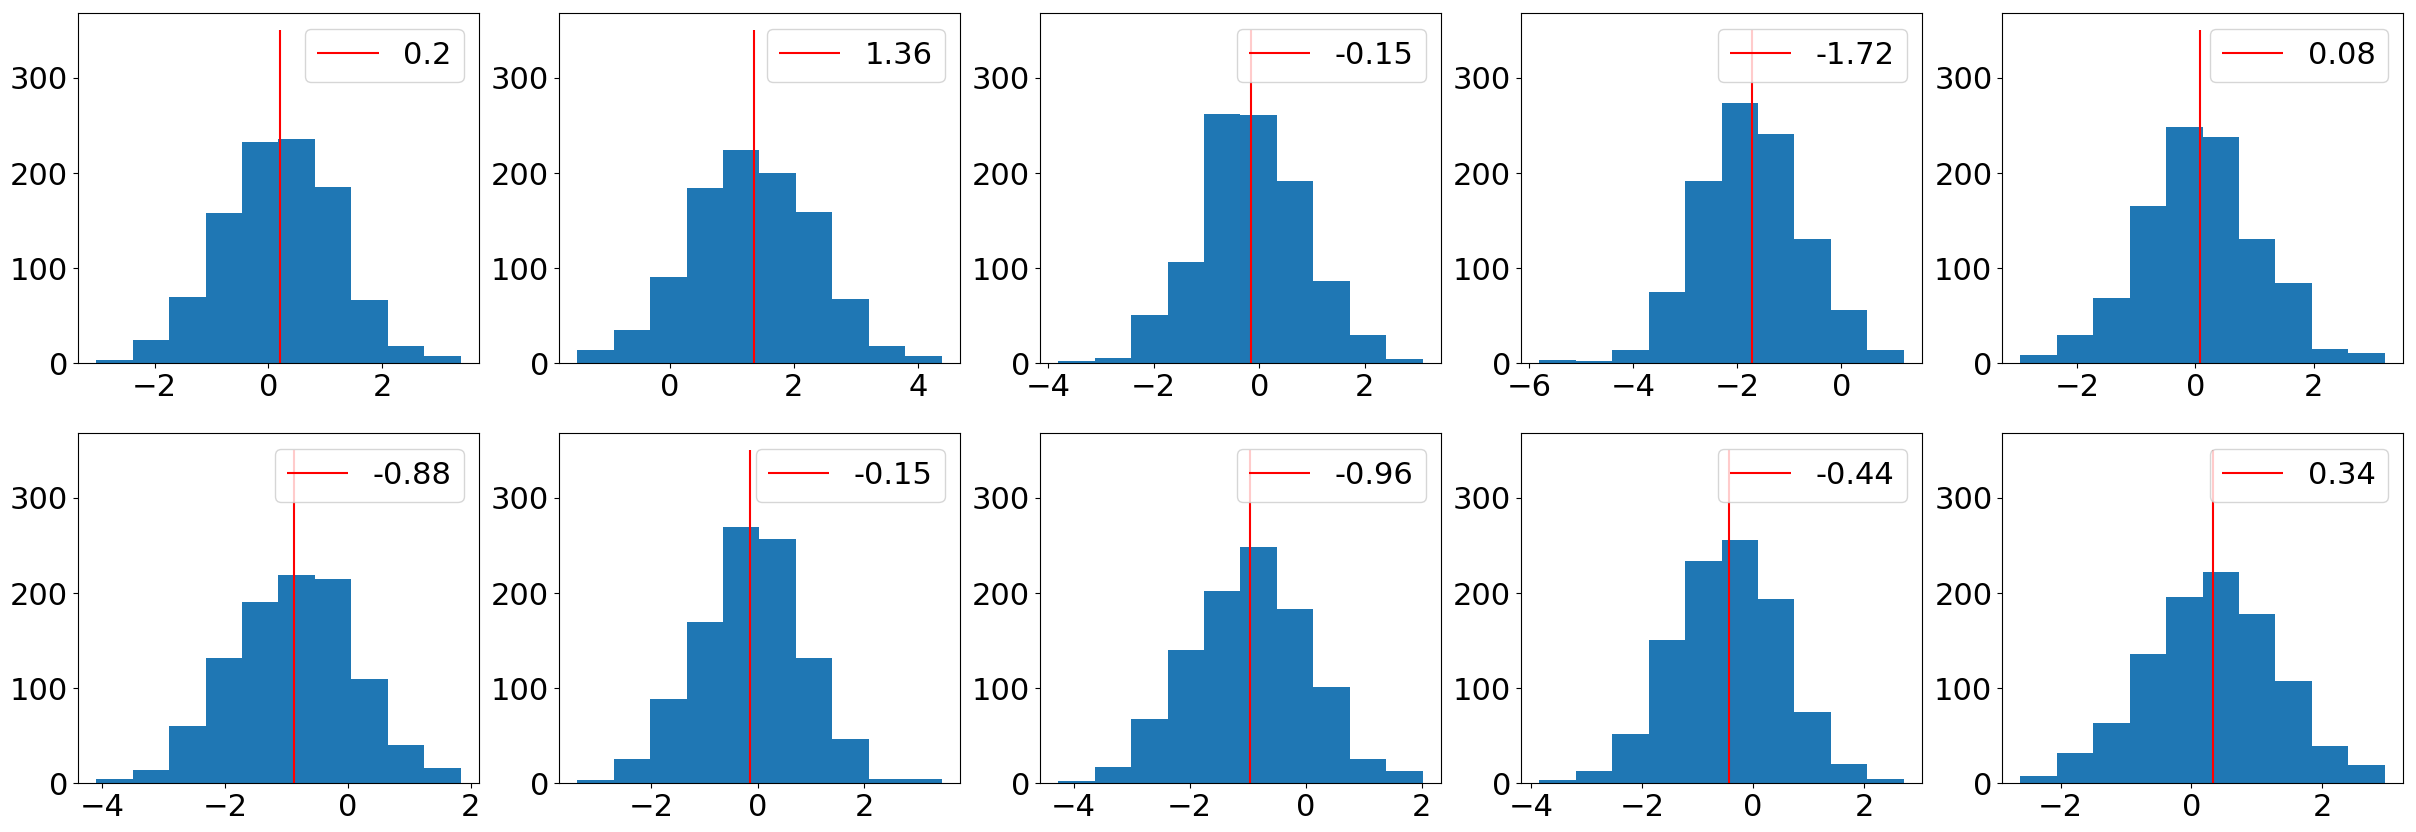

In [12]:
# sample out all 10 different actions(k=10) many times and plot reward histogram, which indicates distribution
history = np.zeros([10,1000])
for i in range(1000):
    for j in range(10):
        history[j][i] = (env_10_arms.sent_reward(j))

plt.figure(figsize=(30,10))

plt.rcParams.update({'font.size': 22})
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.hist(history[i])
    q_a = env_10_arms.q_a[i]
    plt.vlines(x=q_a, ymin=0, ymax=350, colors='r', label=round(q_a,2))
    plt.legend()

plt.show()

In the image above, red lines with red numbers are all q(a). So q(a) are set as expectations of normal distributions, and sample means are usually close to their expecations if sample sizes are larege(large number theorum)

In [13]:
# set agent
class agent(object):
    def __init__(self, environment):
        self.environment = environment
        self.k = environment.k
        self.Q_a = np.zeros([self.k, 2]) # agent use estimation Q(a) to approach q(a)
        self.reward_history = []
    
    def step(self, epsilon):
        lottery = np.random.rand(1)[0] # generate a number between 0 and 1
        if lottery < epsilon: # if less than epsilon, then explore
            idx = np.random.randint(self.k)
            reward = self.environment.sent_reward(idx)
        
        else: # exploit
            import operator
            idx, value = max(enumerate(self.Q_a[:,0]), key=operator.itemgetter(1))
            reward = self.environment.sent_reward(idx)
        
        # here Q_a is actually average reward: sum of total rewards divided by total number this action has been visited
        self.Q_a[idx][1] += 1
        Q_a = self.Q_a[idx][0]
        n = self.Q_a[idx][1]
        # here is a updating formula, it can be interpreted as:
        # actual reward substracts previous estimation Q_a, spread into n steps evenly 
        # and add to old Q_a as new fixed estimation, then set it as new Q_a
        Q_a = Q_a + 1/n * (reward - Q_a)
        self.Q_a[idx][0] = Q_a
        self.reward_history.append(reward)
    
    def reset(self):
        self.Q_a = np.zeros([self.k, 2])
        self.reward_history = []

In [15]:
my_agent = agent(env_10_arms)
for i in range(1000): # try to run 1000 episodes
    my_agent.step(epsilon=0.01)
np.set_printoptions(suppress=True)
print(my_agent.Q_a)

[[  0.2656844  325.        ]
 [  0.           0.        ]
 [ -0.32380839   4.        ]
 [  0.           0.        ]
 [ -0.4994602    2.        ]
 [  0.           0.        ]
 [ -1.1728871    1.        ]
 [ -0.08000765   2.        ]
 [ -0.15452161   3.        ]
 [  0.35960566 663.        ]]


The first colum in  Q_a are average rewards that the agent received, for each action. Second colum are how many times the action has been visited.

Now we use different epsilon run many experiments to get stable results, and compare them togather.

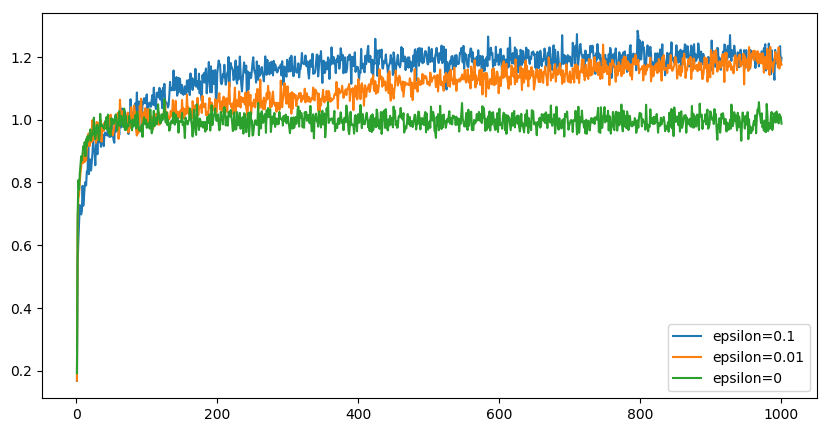

In [16]:
# define a function that help us run episode and plot
def trial_and_plot(agent, epsilon, maxium_step, total_trials, label=None):
    agent.reset()
    agent.environment.reset()
    step_idx = [step+1 for step in range(maxium_step)] # how many step to run in one trial
    cum = np.zeros(maxium_step)
    
    for trial in range(total_trials): # for every trial, we run our agent maxium_step. So every step has total_trials records
        for one_step in range(maxium_step):
            agent.step(epsilon=epsilon)            
        cum += agent.reward_history
        agent.reset()
        agent.environment.reset()
    
    plt.plot(step_idx, cum/total_trials, label=label) # every step reward is averaged along all trials
    plt.legend()
    
plt.figure(figsize=(10,5))
plt.rcParams.update(plt.rcParamsDefault)
trial_and_plot(my_agent, epsilon=0.1,  maxium_step=1000, total_trials=2000, label='epsilon=0.1')
trial_and_plot(my_agent, epsilon=0.01, maxium_step=1000, total_trials=2000, label='epsilon=0.01')
trial_and_plot(my_agent, epsilon=0   , maxium_step=1000, total_trials=2000, label='epsilon=0')

From picture above, we can see that total greedy(epsilon=0) algorithm goes fast and better at begining but plateau very soon and doesn't improve any more. While epsilon=0.01 greedy algorithm moves slowly but soon catch up compare to epsilon=0.1 greedy.

## 2. None-stationary setting

Similarly, we can make the environment have none stationary q_a by injecting some noise every step.

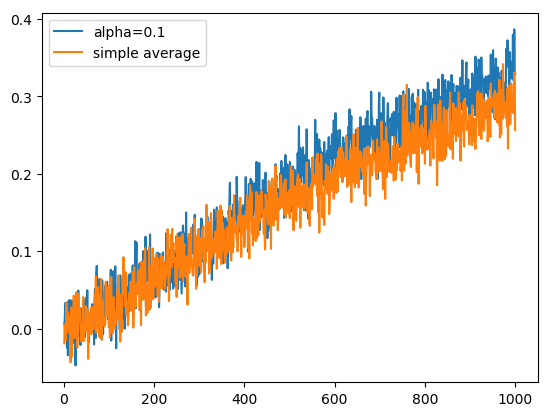

In [18]:
class nonstationary_k_bandith(object):
    def __init__(self, k):
        self._k = k
        self.q_a = np.zeros(k) # all q_a starting out equal
    
    def sent_reward(self, action_idx):
        reward = np.random.normal(loc=self.q_a[action_idx], scale=1.0)        
        injection = np.random.normal(loc=0, scale=0.01, size=self._k)
        self.q_a += injection # inject noise so that every q_a is random walk
        return reward
    
    def reset(self):
        self.q_a = np.zeros(self._k)
        
    @property
    def k(self):
        return self._k

class agent2(object):
    def __init__(self, environment, alpha):
        self.environment = environment
        self.alpha = alpha
        self.k = environment.k
        self.q_a = np.zeros([self.k, 2])
        self.reward_history = []
    
    def step(self, epsilon):
        lottery = np.random.rand(1)[0]
        if lottery < epsilon: # explore
            idx = np.random.randint(self.k)
            reward = self.environment.sent_reward(idx)
        
        else:
            import operator
            idx, value = max(enumerate(self.q_a[:,0]), key=operator.itemgetter(1))
            reward = self.environment.sent_reward(idx)
        
        self.q_a[idx][1] += 1
        q_a = self.q_a[idx][0]
        n = self.q_a[idx][1]
        q_a = q_a + self.alpha * (reward - q_a) # replace 1/n with alpha so only latest rewards matters more, which is 
                                                # reasonalbe chioce when the environment changes along time, earlier information
                                                # loses its reference importance.
        self.q_a[idx][0] = q_a
        self.reward_history.append(reward)
    
    def reset(self):
        self.q_a = np.zeros([self.k, 2])
        self.reward_history = []
        
environ2 = nonstationary_k_bandith(10)
        
my_agent_alpha = agent2(environ2, 0.1) # set alpha=0.1
my_agent2 = agent(environ2)

trial_and_plot(my_agent_alpha, epsilon=0.1,  maxium_step=1000, total_trials=2000, label='alpha=0.1')
trial_and_plot(my_agent2, epsilon=0.1,  maxium_step=1000, total_trials=2000, label='simple average')    

Although vibrating, alpha-greedy works better than simple average greedy in none-stationary setting